# PS3: Deep learning

In this problem set, you will experiment with fully-connected neural networks.

To start with, let's load the "breast cancer" data set from scikit-learn:

In [5]:
import numpy as np
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt

data = load_breast_cancer()
y = np.matrix(data.target).T
X = np.matrix(data.data)
M = X.shape[0]
N = X.shape[1]

# Normalize each input feature

def normalize(X):
    M = X.shape[0]
    XX = X - np.tile(np.mean(X,0),[M,1])
    XX = np.divide(XX, np.tile(np.std(XX,0),[M,1]))
    return XX

XX = normalize(X)

Next, let's represent a fully-connected neural network by two arrays W and b containing the weights and biases for each layer.

In [6]:
h = 5
W = [[], np.random.normal(0,0.1,[N,h]), np.random.normal(0,0.1,[h,1])]
b = [[], np.random.normal(0,0.1,[h,1]), np.random.normal(0,0.1,[1,1])]
L = len(W)-1

def act(z):
    return 1/(1+np.exp(-z))

def actder(z):
    az = act(z)
    prod = np.multiply(az,1-az)
    return prod

def ff(x,W,b):
    L = len(W)-1
    a = x
    for l in range(1,L+1):
        z = W[l].T*a+b[l]
        a = act(z)
    return a

def loss(y,yhat):
    return np.sum(-(np.multiply((1-y), np.log(1-yhat)) + np.multiply(y, np.log(yhat))), axis = 0)

## Question 1

Write Python code to separate $\texttt{X},\texttt{y}$ randomly into a training set containing 80% of the data and a validation set consisting of the remaining 20% of the data.

In [11]:
# Code goes here
X_train = XX[:455]
y_train = y[:455]
X_test = XX[455:]
y_test = y[455:]
print(y_train)

[[0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [0]
 [1]
 [0]
 [1]
 [1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [1]
 [0]
 [0]
 [0]
 [0]


## Question 2

Beginning with the training code we wrote together in class, write Python code to execute backpropagation with mini-batch size 1 on the training set, and plot the training loss and validation loss as a function of training iteration. Show the plot in this sheet.

In [8]:
class NN(object):
    def __init__(self, X, y, no_of_units = [1, 1], no_of_layers=2, use_relu = False, threshold_exp = False):
        """
        self.X: training set input features
        self.y: training set output for corresponding features
        self.no_of_units: list of number of units in each layer
        """
        super(NN, self).__init__()
        self.X = X
        self.y = y
        self.no_of_units = no_of_units
        self.use_relu = use_relu
        self.threshold_exp = threshold_exp
        N = X.shape[1]
        
        self.W = [[]]
        self.b = [[]]
        for i in range(0, no_of_layers-1):
            self.W.append(np.random.normal(0, 0.1, [no_of_units[i], no_of_units[i+1]]))
            self.b.append(np.random.normal(0, 0.1, [no_of_units[i+1], 1]))
        
        self.is_trained = False;

    def _sigmoid(self, z):
        """
        Activation Function
        """
        exp = np.exp(-z)
        if self.threshold_exp:
            exp[exp<1e-6] = 1e-6
        return 1/(1+exp)

    def _sigmoid_der(self, z):
        """
        derivative of activation function
        """
        az = self._sigmoid(z)
        prod = np.multiply(az,1-az)
        return prod
    
    def _relu(self, z):
        z[z<0] = 0
        return z
        
    def _relu_der(self, z):
        z[z<0] = 0
        z[z>0] = 1
        return z
        
    def _validate(self, X, y, to_print=False):
        M = X.shape[0]
        N = X.shape[1]
        L = len(self.W)-1
        total_loss = 0
        for i in range(0, M):
            x_this = X[i, :].T
            y_this = y[i, 0]
            
            # Feed Forward
            a = [x_this]
            z = [[]]
            for l in range(1, L+1):
                z.append(self.W[l].T*a[l-1]+self.b[l])
                if self.use_relu and l < L:
                    a.append(self._relu(z[l]))
                else:
                    a.append(self._sigmoid(z[l]))
                
            total_loss += loss(y_this,a[L][0,0])
        if to_print:
            print("Validation loss: %f" % (total_loss))
        return total_loss

    def train(self, alpha=0.01, max_iter=1000, X_validation = None, y_validation = None):
        M = self.X.shape[0]
        N = self.X.shape[1]
        L = len(self.W)-1
        
        train_losses = []
        validation_losses = []
        
        for iter in range(0, max_iter):
            loss_this_iter = 0
            for i in range(0, M):
                x_this = self.X[i, :].T
                y_this = self.y[i, 0]
                
                # Feed Forward
                a = [x_this]
                z = [[]]
                delta = [[]]
                dW = [[]]
                db = [[]]
                for l in range(1, L+1):
                    z.append(self.W[l].T*a[l-1]+self.b[l])
                    if self.use_relu and l < L:
                        a.append(self._relu(z[l]))
                    else:
                        a.append(self._sigmoid(z[l]))
                    # Just to give arrays the right shape for the backprop step
                    delta.append([]); dW.append([]); db.append([])
                    
                loss_this_pattern = loss(y_this,a[L][0,0])
                loss_this_iter = loss_this_iter + loss_this_pattern
                
                # Back propogation
                delta[L] = a[L] - y_this
                for l in range(L,0,-1):
                    db[l] = delta[l].copy()
                    dW[l] = a[l-1] * delta[l].T
                    if l > 1:
                        if l != L and self.use_relu:
                            delta[l-1] = np.multiply(self.W[l], self._relu_der(z[l-1])) * delta[l]
                        else:
                            delta[l-1] = np.multiply(self.W[l], self._sigmoid_der(z[l-1])) * delta[l]
                            
                            
                # Update weights and biases
                for l in range(1,L+1):            
                    self.W[l] = self.W[l] - alpha * dW[l]
                    self.b[l] = self.b[l] - alpha * db[l]
                # Validation
            test_loss = 0
            if (X_validation is not None) and (y_validation is not None):
                test_loss = self._validate(X_validation, y_validation)
#             print('Iteration %d loss %f %f' % (iter, loss_this_iter, test_loss))
            train_losses.append(loss_this_iter)
            validation_losses.append(test_loss)
        
        self.is_trained = True
        return train_losses, validation_losses

Final train loss: 21.163540583032564
Final validation loss: 9.491475167569149


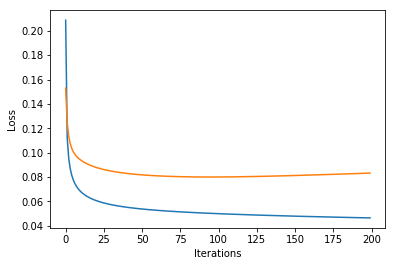

In [10]:
iterations = 200
obj = NN(X_train,
         y_train,
         no_of_units=[X_train.shape[1], y_train.shape[1]],
         no_of_layers=2)
train_losses, validation_losses = obj.train(max_iter=iterations,
                                            X_validation=X_test,
                                            y_validation=y_test,
                                            alpha=0.01)
print("Final train loss:", train_losses[-1])
print("Final validation loss:", validation_losses[-1])
# Plot iterations vs loss graph
plt.plot(range(iterations), np.array(train_losses)/X_train.shape[0])
plt.plot(range(iterations), np.array(validation_losses)/X_test.shape[0])

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()

## Question 3

Perform several experiments with different numbers of layers and different numbers of hidden units. Demonstrate the phenomenon of overtraining, make a table showing the training and validation set performance of each of your models, and make a recommendation about which model is best based on validation set performance.

Final train loss: 2.0874994217935856
Final validation loss: 10.651477517766184


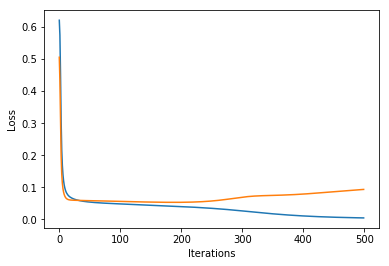

In [38]:
############## over training #############################
iterations = 500
overFittingNN = NN(X_train, y_train,
                   no_of_units=[X_train.shape[1],100, 50, y_train.shape[1]],
                   no_of_layers=4)
train_losses, validation_losses = overFittingNN.train(max_iter=iterations,
                                                      X_validation=X_test,
                                                      y_validation=y_test,
                                                      alpha=0.01)
print("Final train loss:", train_losses[-1])
print("Final validation loss:", validation_losses[-1])
# Plot iterations vs loss graph
plt.plot(range(iterations), np.array(train_losses)/X_train.shape[0])
plt.plot(range(iterations), np.array(validation_losses)/X_test.shape[0])

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()

Final train loss: 5.639003021864466
Final validation loss: 7.41323684772695


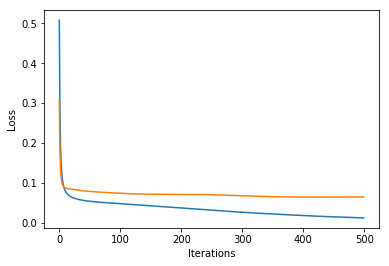

In [33]:
##############  Good Model #############################
iterations = 500
goodNN = NN(X_train, y_train,
                   no_of_units=[X_train.shape[1], 30,y_train.shape[1]],
                   no_of_layers=3)
train_losses, validation_losses = goodNN.train(max_iter=iterations,
                                                X_validation=X_test,
                                                y_validation=y_test,
                                                alpha=0.01)
print("Final train loss:", train_losses[-1])
print("Final validation loss:", validation_losses[-1])
# Plot iterations vs loss graph
plt.plot(range(iterations), np.array(train_losses)/X_train.shape[0])
plt.plot(range(iterations), np.array(validation_losses)/X_test.shape[0])

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()

*Results table and discussion goes here.*
<table>
    <tr>
        <th>no. of hidden layers</th>
        <th>no. of units</th>
        <th>training set loss</th>
        <th>validation set loss</th>
    </tr>
    <tr>
        <td>2</td>
        <td>| 100 | 50 |</td>
        <td>1.8481840442783546</td>
        <td>11.375613116702937</td>
    </tr>    
    <tr>
        <td>1</td>
        <td>| 30 |</td>
        <td>5.158314275577264</td>
        <td>7.1319545994074645</td>
    </tr>
</table>

When using 2 hidden layers with 100 and 50 units each, we observe over training because of increased complexity. When using a single layer with 30 units, we see a good training and validation loss.

## Question 4

Modify the backpropagation procedure to use mini-batches of a few different sizes such as 10, 20, and 40. Take care that each mathematical operation is efficient (avoid any for loops over the examples in a mini-batch). Repeat your experiments and report the results. Do you observe any differences in terms of accuracy and number of iterations to converge?

/media/storage/college/ML/env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: overflow encountered in exp


Final train loss: 592.5608507999251
Final validation loss: 124.48248443742918


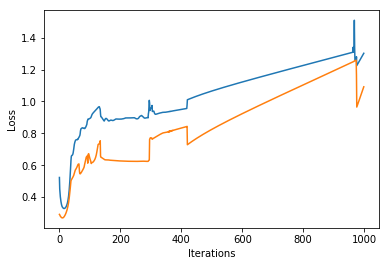

In [40]:
def loss(y,yhat):
    return -(np.multiply((1-y), np.log(1-yhat)) + np.multiply(y , np.log(yhat)))

class NN_Mini_Batch(object):
    def __init__(self, X, y, no_of_units = [1, 1], no_of_layers=2, use_relu = False, threshold_exp = False):
        """
        self.X: training set input features
        self.y: training set output for corresponding features
        self.no_of_units: list of number of units in each layer
        """
        super(NN_Mini_Batch, self).__init__()
        self.X = X
        self.y = y
        self.no_of_units = no_of_units
        self.use_relu = use_relu
        self.threshold_exp = threshold_exp
        N = X.shape[1]
        
        self.W = [[]]
        self.b = [[]]
        for i in range(0, no_of_layers-1):
            self.W.append(np.random.normal(0, 0.1, [no_of_units[i], no_of_units[i+1]]))
            self.b.append(np.random.normal(0, 0.1, [no_of_units[i+1], 1]))
        
        self.is_trained = False;

    def _sigmoid(self, z):
        """
        Activation Function
        """
        ez = np.exp(-z)
        if self.threshold_exp:
            ez[ez<1e-6] = 1e-6
        return 1/(1+ez)

    def _sigmoid_der(self, z):
        """
        derivative of activation function
        """
        az = self._sigmoid(z)
        prod = np.multiply(az,1-az)
        return prod
    
    def _relu(self, z):
        z[z<0] = 0
        return z
        
    def _relu_der(self, z):
        z[z<0] = 0
        z[z>0] = 1
        return z
        
    def _validate(self, X, y, to_print=False):
        M = X.shape[0]
        N = X.shape[1]
        L = len(self.W)-1
        total_loss = 0
        for i in range(0, M):
            x_this = X[i, :].T
            y_this = y[i, 0]
            # Feed Forward
            a = [x_this]
            z = [[]]
            for l in range(1, L+1):
                z.append(self.W[l].T*a[l-1]+self.b[l])
                if self.use_relu and l < L:
                    a.append(self._relu(z[l]))
                else:
                    a.append(self._sigmoid(z[l]))
            pattern_loss = loss(y_this,a[L][0,0]) 
            total_loss = total_loss + pattern_loss 
        if to_print:
            print("Validation loss: %f" % (total_loss))
        return total_loss

    def train(self, alpha=0.01, max_iter=1000, X_validation = None, y_validation = None, batch_size = 1):
        
        M = self.X.shape[0]
        N = self.X.shape[1]
        L = len(self.W)-1
        
        train_losses = []
        validation_losses = []
        order = np.random.permutation(M)
        for iter in range(0, max_iter):
            loss_this_iter = 0
            
            for i in range(0, int(M/batch_size)):
                x_this = self.X[order[i]:order[i]+batch_size, :].T
                y_this = self.y[order[i]:order[i]+batch_size, :]
                
                # Feed Forward
                a = [x_this]
                z = [[]]
                delta = [[]]
                dW = [[]]
                db = [[]]
                for l in range(1, L+1):
                    z.append(self.W[l].T*a[l-1]+self.b[l])
                    if self.use_relu and l < L:
                        a.append(self._relu(z[l]))
                    else:
                        a.append(self._sigmoid(z[l]))
                    # Just to give arrays the right shape for the backprop step
                    delta.append([]); dW.append([]); db.append([])
                    
                loss_this_pattern = np.sum(loss(y_this,a[L].T))
                loss_this_iter = loss_this_iter + loss_this_pattern
                
                # Back propogation
                delta[L] = np.sum(a[L].transpose() - y_this, axis=0)
                for l in range(L,0,-1):
                    db[l] = delta[l].copy()
                    dW[l] = np.sum(a[l-1],axis=1) * delta[l].transpose()
                    if l > 1:
                        if l != L and self.use_relu:
                            delta[l-1] = np.sum(np.multiply(self._relu_der(z[l-1]) , self.W[l] * delta[l]), axis=1)
                        else:
                            delta[l-1] = np.sum(np.multiply(self._sigmoid_der(z[l-1]) , self.W[l] * delta[l]), axis=1)
                           
                # Update weights and biases
                for l in range(1,L+1):            
                    self.W[l] = self.W[l] - alpha * dW[l]
                    self.b[l] = self.b[l] - alpha * db[l]
                    
            # Validation
            test_loss = 0
#             if (X_validation is not None) and (y_validation is not None):
            test_loss = self._validate(X_validation, y_validation)
#             print('Iteration %d loss %f %f' % (iter, loss_this_iter, test_loss))
            train_losses.append(loss_this_iter)
            validation_losses.append(test_loss)
        
        self.is_trained = True
        return train_losses, validation_losses
# Code goes here
iterations = 1000
obj = NN_Mini_Batch(X_train, y_train,
         no_of_units=[X_train.shape[1], 5, y_train.shape[1]],
         no_of_layers=3,
         threshold_exp=True)
train_losses, validation_losses = obj.train(max_iter=iterations,
                                            X_validation=X_test,
                                            y_validation=y_test,
                                            alpha=0.01,
                                            batch_size = 20)
print("Final train loss:", train_losses[-1])
print("Final validation loss:", validation_losses[-1])
# Plot iterations vs loss graph
plt.plot(range(iterations), np.array(train_losses)/X_train.shape[0])
plt.plot(range(iterations), np.array(validation_losses)/X_test.shape[0])

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()

*Results table and discussion goes here.*

## Question 5

Modify the model to use the ReLU activation function in the hidden layers rather than logistic sigmoid. Repeat your experiments and report the results. Do you observe any differences in terms of accuracy and number of iterations to converge?

Final train loss: 0.5706426794767718
Final validation loss: 10.946395007619707


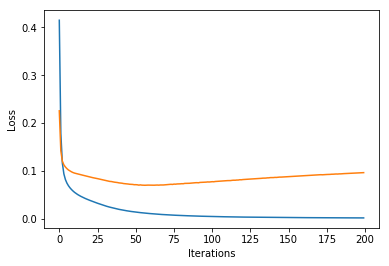

In [31]:
# Code goes here
iterations = 200
obj = NN(X_train, y_train,
         no_of_units=[X_train.shape[1], 100, 50, y_train.shape[1]],
         no_of_layers=4,
         use_relu=True,
        threshold_exp=True)
train_losses, validation_losses = obj.train(max_iter=iterations,
                                            X_validation=X_test,
                                            y_validation=y_test,
                                            alpha=0.01)
print("Final train loss:", train_losses[-1])
print("Final validation loss:", validation_losses[-1])
# Plot iterations vs loss graph
plt.plot(range(iterations), np.array(train_losses)/X_train.shape[0])
plt.plot(range(iterations), np.array(validation_losses)/X_test.shape[0])

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()

Final train loss: 38.48432525483472
Final validation loss: 12.182051426231551


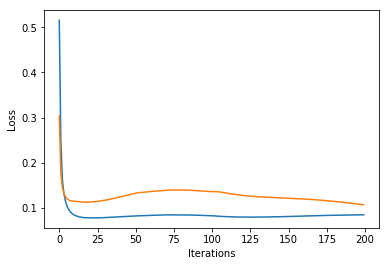

In [30]:
# Code goes here
iterations = 200
obj = NN(X_train, y_train,
         no_of_units=[X_train.shape[1], 5, y_train.shape[1]],
         no_of_layers=3,
         use_relu=True,
         threshold_exp=True)
train_losses, validation_losses = obj.train(max_iter=iterations,
                                            X_validation=X_test,
                                            y_validation=y_test,
                                            alpha=0.01)
print("Final train loss:", train_losses[-1])
print("Final validation loss:", validation_losses[-1])
# Plot iterations vs loss graph
plt.plot(range(iterations), np.array(train_losses)/X_train.shape[0])
plt.plot(range(iterations), np.array(validation_losses)/X_test.shape[0])

plt.xlabel("Iterations")
plt.ylabel("Loss")

plt.show()

*Results table and discussion goes here.*
<table>
    <tr>
        <th>no. of hidden layers</th>
        <th>no. of units</th>
        <th>training set loss</th>
        <th>validation set loss</th>
    </tr>
    <tr>
        <td>2</td>
        <td>| 100 | 50 |</td>
        <td>0.5410274677318734</td>
        <td>9.080624856755017</td>
    </tr>    
    <tr>
        <td>1</td>
        <td>| 30 |</td>
        <td>39.83450917661596</td>
        <td>16.412250725274784</td>
    </tr>
</table>

When using 2 hidden layers with 100 and 50 units each, we observe over training because of increased complexity. When using a single layer with 30 units, we see a better model.